In [51]:
# %matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import optimize
from scipy import signal
# from scipy.signal.signaltools import choose_conv_method
# import os

## Data preset

In [52]:
Atom = "Fe"
Path = r"C:\Researches\Data\MPS3\202103_2"
energyDispersion = 0.0078  # eV
refElasticPixel = 5600

In [53]:
def MakeFileName(scanNumber):
    global Atom
    if scanNumber < 10:
        fileName = Atom + "_" + "000" + str(scanNumber)
    elif scanNumber < 100:
        fileName = Atom + "_" + "00" + str(scanNumber)
    elif scanNumber < 1000:
        fileName = Atom + "_" + "0" + str(scanNumber)
    else:
        fileName = Atom + "_" + str(scanNumber)
    return fileName

def Gaussian_amp(x,xc,fwhm,amp):
    return amp*np.exp(-4*np.log(2)*(x-xc)**2/(fwhm)**2)

def xCorrElastic(xAxis,uncorrData):
    global refElasticPixel
    peaks, _ = signal.find_peaks(
        uncorrData, height=np.max(uncorrData) / 20, width=3
    )
    uncorrData= np.roll(uncorrData, refElasticPixel - peaks[-1])

    popt, pcov = optimize.curve_fit(
        Gaussian_amp,
        xAxis,
        uncorrData,
        p0=[refElasticPixel, 10, np.max(uncorrData)/20],
    )
    corrData= np.roll(uncorrData, refElasticPixel - round(popt[0]))
    corrAxis = np.array(popt[0]-round(popt[0]) + refElasticPixel - xAxis)
    return corrAxis,corrData

def xCorr(refData, uncorrData):
    corr = signal.correlate(refData, uncorrData)  # consider full pattern
    lags = signal.correlation_lags(len(refData), len(uncorrData))
    lag = lags[np.argmax(corr)]
    uncorrData = np.roll(uncorrData, lag)

    corr = signal.correlate(refData, uncorrData)  # consider full pattern
    lags = signal.correlation_lags(len(refData), len(uncorrData))    
    lag = lags[np.argmax(corr)]
    corrData = np.roll(uncorrData, lag)
    return corrData

def EnergyTrans(rawData):
    global energyDispersion
    pixel = np.arange(len(rawData))
    pixelAxis,pixelData = xCorrElastic(pixel,rawData)
    energyAxis = np.array(pixelAxis * energyDispersion)
    return energyAxis,pixelData

def GetData(scanNumber):
    global Path
    f1 = h5py.File(Path + "\\RIXS\\" + MakeFileName(scanNumber) + "_d1.h5", "r")
    f2 = h5py.File(Path + "\\RIXS\\" + MakeFileName(scanNumber) + "_d2.h5", "r")
    f3 = h5py.File(Path + "\\RIXS\\" + MakeFileName(scanNumber) + "_d3.h5", "r")
    ccd1 = f1["entry"]["analysis"]["spectrum"][()]
    ccd2 = f2["entry"]["analysis"]["spectrum"][()]
    ccd3 = f3["entry"]["analysis"]["spectrum"][()]
    acqTime1 = np.mean(f1["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    acqTime2 = np.mean(f2["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    acqTime3 = np.mean(f3["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    ccd = (xCorr(ccd2, ccd1) + ccd2 + xCorr(ccd2, ccd3)) / 3
    acqTime = (acqTime1 + acqTime2 + acqTime3) / 3
    return ccd, acqTime


def CombineData(scans):
    refData, totalTime = GetData(scans[0])
    data = refData
    for x in scans[1:]:
        tempData, oneTime = GetData(x)
        data = data + xCorr(refData, tempData)
        totalTime = totalTime + oneTime
    pixelData = data / totalTime * 300  # normalize to 5 minutes
    energyAxis,energyData = EnergyTrans(pixelData)
    return [energyAxis,energyData]

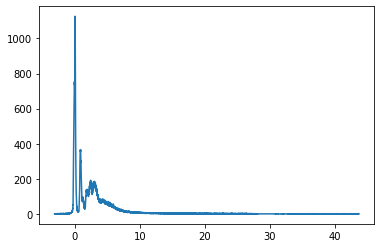

In [63]:
fig = plt.figure()
[X,Y]=CombineData([18])   #scan number
plt.plot(X,Y)
# plt.xlim([-0.5,0.5])

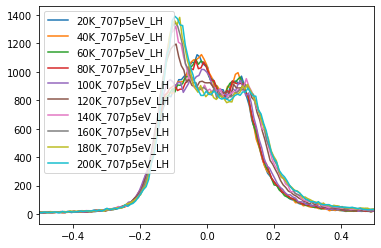

In [64]:
# %%
zipLog = {
    "20K_707p5eV_LH": [24],
    "40K_707p5eV_LH": [34],
    "60K_707p5eV_LH": [42],
    "80K_707p5eV_LH": [50],
    "100K_707p5eV_LH": [58],
    "120K_707p5eV_LH": [66],
    "140K_707p5eV_LH": [74],
    "160K_707p5eV_LH": [82],
    "180K_707p5eV_LH": [90],
    "200K_707p5eV_LH": [98],
}

for i, key in enumerate(zipLog):
    [X,Y]=CombineData(zipLog[key])
    plt.plot(X,Y,label=key)

plt.xlim([-0.5,0.5])
plt.legend()

<ipython-input-7-405f39719ca0>:16: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=60)


Text(0.5, 1.0, 'Energy map')

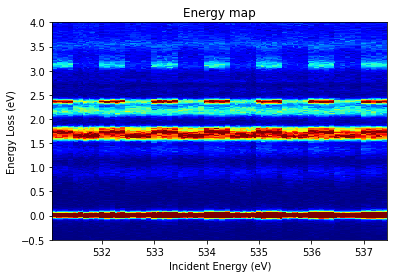

In [ ]:
fig = plt.figure()

scans = np.arange(11,74+1)
Ei = np.arange(531.1,537.4+0.05,0.1)
eiNum = len(scans)

matrixData = np.zeros(((dataLength+100), eiNum))
matrixEloss = np.zeros(((dataLength+100), eiNum))
matrixEi,_ = np.meshgrid(Ei,np.arange(dataLength+100))

for i,s in enumerate(scans):
    [Eloss,oneData] = getdata(s)
    matrixData[:,i] = oneData.T
    matrixEloss[:,i] = Eloss.T

plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=60)
plt.ylim([-0.5,4])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('Energy map')

In [ ]:
# def Gauss_norm(x,xc,sigma,area):
#     norm = 1./sigma/2/np.sqrt(np.pi/2)
#     return area*norm*np.exp(-2*(x-xc)**2/(sigma*2)**2)

# def Gaussian_norm(x,xc,fwhm,area):
#     norm = 1./fwhm/np.sqrt(np.pi/4/np.log(2))
#     return area*norm*np.exp(-4*np.log(2)*(x-xc)**2/(fwhm)**2)

# def Gauss_amp(x,xc,sigma,amp):
#     return amp*np.exp(-2*(x-xc)**2/(sigma*2)**2)

# def Gaussian_amp(x,xc,fwhm,amp):
#     return amp*np.exp(-4*np.log(2)*(x-xc)**2/(fwhm)**2)

# def Lorentz_norm(x,xc,fwhm,area):
#     return 2*area/np.pi*fwhm/(4*(x-xc)**2+fwhm**2)

# def Lorentz_amp(x,xc,fwhm,amp):
#     area = amp*fwhm*np.pi/2
#     return 2*area/np.pi*fwhm/(4*(x-xc)**2+fwhm**2)

# def PsdVoigt(x,xc,area,wG,wL,mu):
#     # wG = 0.85 * wG
#     # wL = wG;
#     # mu = 1.0;
#     return area*(mu*2/np.pi*wL/(4*(x-xc)**2+wL**2)+(1-mu)*np.sqrt(4*np.log(2.))/np.sqrt(np.pi)/wG*np.exp(-4*np.log(2.)*(x-xc)**2/wG**2))
